# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP

## Content
----

- [Data Cleaning](#Data-Cleaning)
- [EDA](#EDA)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Model Comparison](#Model-Comparison)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Data Cleaning
---

In [1]:
import pandas as pd
import regex as re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from wordcloud import WordCloud

from IPython.display import display

from bs4 import BeautifulSoup

### Creating functions for data cleaning

Function to clean dataset in general

In [2]:
def dataset_cleaning (dataset, topic):
    
    # 1. Replace null, [removed] and [deleted] comments with empty space in the selftext column
    dataset["selftext"].fillna("", inplace=True)
    dataset["selftext"].replace("[removed]", "",inplace=True)
    dataset["selftext"].replace("[deleted]", "",inplace=True)
    
    # 2. Drop duplicates in the dataset
    dataset.drop_duplicates(subset = ["title"], keep='first', inplace=True)
    
    # 3. Add both title and selftext to form a new column
    dataset["alltext"] = dataset["title"] + " " + dataset["selftext"]
    
    # 4. Drop both title and selftext since there is a consolidated column now
    dataset.drop(["title", "selftext"], axis=1, inplace=True)
    
    # 5. Create a new column for topic
    dataset["topic"] = topic
    

<br>
Function to clean the words

In [3]:
def chunks_to_words(raw_chunks):

    # 1. Remove url links. 
    alltext = re.sub(r"http\S+", "", raw_chunks)
    
    # 2. Remove HTML.
    review_text = BeautifulSoup(alltext).get_text()
    
    # 3. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 4. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 5. Convert the stopwords into a set
    stops = set(stopwords.words('english'))
    
    # 6. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # 7. Lemmatize the words.
    lemmatizer = WordNetLemmatizer()    
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(tokens_lem))

### Explore LOTR dataset

In [4]:
lotr_df = pd.read_csv("./data/lordoftherings.csv")

In [5]:
lotr_df

,subreddit,title,selftext
0,lordoftherings,How this sub acts in every comment section abo...,NaN
1,lordoftherings,how forgiving is Eru,I am making a maia that fell from grace due to...
2,lordoftherings,Music changes everything,NaN
3,lordoftherings,Everything the RoP showrunners have said in in...,Some common critiques fans have for the showru...
4,lordoftherings,Fights when well choreographed despite being s...,NaN
...,...,...,...
1794,lordoftherings,Gondolin by Donato Giancola,NaN
1795,lordoftherings,Question about that scene in Two Towers with A...,hello! it’s my first time watching the movies ...
1796,lordoftherings,It's probably the coolest piece I own now.,NaN
1797,lordoftherings,My most favorite one,NaN


In [6]:
lotr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1799 non-null   object
 1   title      1799 non-null   object
 2   selftext   454 non-null    object
dtypes: object(3)
memory usage: 42.3+ KB


#### Clean LOTR data

Using the 2 functions to clean the LOTR data

In [7]:
dataset_cleaning(lotr_df, "LOTR")

In [8]:
lotr_df["alltext"] = lotr_df["alltext"].map(chunks_to_words)

C:\Users\cheon\anaconda3\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
lotr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1714 entries, 0 to 1798
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1714 non-null   object
 1   alltext    1714 non-null   object
 2   topic      1714 non-null   object
dtypes: object(3)
memory usage: 53.6+ KB


#### Find popular words in LOTR dataset

<br>
Enhancing the list of stopwords from Count Vectorizer

In [10]:
stopwords_enhanced = []

In [11]:
stopwords_enhanced.append(CountVectorizer(stop_words = 'english').get_stop_words())

_This list of extra words was done after doing the vectorization once._
<br>
_This list of extra words was also refined after modelling to improve the performance._

In [12]:
extra_words = ["got", "also", "think", "really", "know", "would", "made", "make", "get", "see", "says", "look", "sweet", "nice",
               "one", "like", "could", "anyone", "much", "read", "show", "chapter", "anyone", "time", "pen", "figured", "page", "father",
               "film", "amazing", "piece", "christmas", "bit", "finish", "marketing", "thought", "might", "house", "game", "perfect",  
               "place", "help", "never", "something", "go", "version", "way", "want", "best", "ever", "back", "good", "year", "later",
               "find", "even", "love", "many", "thing", "well", "little", "video", "feel", "favourite", "rather", "drawing", "fav", "generated", 
               "quiz", "bear", "anime", "happy", "exclusive", "dramatic", "local", "print", "child", "mug", "fanedit", "meme", "imagined", "ball",
               "thanks", "everyone", "great", "first", "book", "movie", "new", "always", "better", "big", "view", "watch", "actually", "trailer"]

In [13]:
for word in extra_words:
    stopwords_enhanced.append(word)

<br>
Vectorize the LOTR dataset to find popular words

In [14]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords_enhanced,
                             ngram_range =(1, 4),
                             max_features = 100
                            ) 

In [15]:
vector_lotr = vectorizer.fit_transform(lotr_df["alltext"])

In [16]:
vector_lotr.shape

(1714, 100)

In [17]:
vector_lotr_df = pd.DataFrame(vector_lotr.todense(),
                              columns=vectorizer.get_feature_names_out())

In [18]:
vector_lotr_df

,age,amazon,aragorn,art,battle,bilbo,black,cast,character,come,...,today,tolkien,tower,trilogy,two,wanted,war,watching,work,world
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,10,0,0,2,0,0,1,8,7,...,0,39,1,2,11,13,2,0,5,16
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1711,0,0,2,0,0,0,0,0,0,0,...,0,0,2,0,2,0,0,1,0,0
1712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Explore The Hobbits dataset

In [19]:
hobb_df = pd.read_csv("./data/thehobbits.csv")

In [20]:
hobb_df.shape

(1800, 3)

#### Clean Hobbit data

In [21]:
dataset_cleaning(hobb_df, "HOBB")

In [22]:
hobb_df["alltext"] = hobb_df["alltext"].map(chunks_to_words)

C:\Users\cheon\anaconda3\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
hobb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1656 non-null   object
 1   alltext    1656 non-null   object
 2   topic      1656 non-null   object
dtypes: object(3)
memory usage: 51.8+ KB


#### Find popular words in Hobbit dataset

In [24]:
vector_hobb = vectorizer.fit_transform(hobb_df["alltext"])

In [25]:
vector_hobb.shape

(1656, 100)

In [26]:
vector_hobb_df = pd.DataFrame(vector_hobb.todense(),
                              columns = vectorizer.get_feature_names_out())

In [27]:
vector_hobb_df

,adventure,answer,army,art,azog,baggins,battle,battle five,battle five army,bilbo,...,tolkien,trilogy,two,unexpected,wanted,war,watched,watching,work,world
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1652,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA

### Find the top common words in both dataset

<AxesSubplot:>

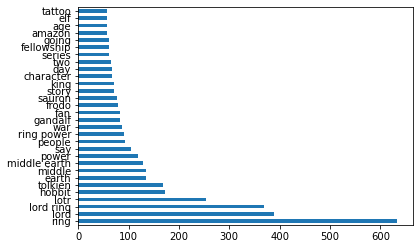

In [28]:
vector_lotr_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")

<AxesSubplot:>

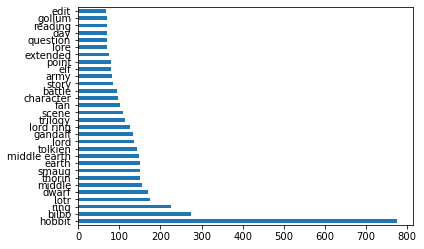

In [29]:
vector_hobb_df.sum().sort_values(ascending=False).head(30).plot(kind="barh")

Remove the common words

In [30]:
lotr_df.replace(["middle earth", "lord ring", "middle", "earth", "ring", "tolkien", "lord"], "", inplace=True)
hobb_df.replace(["middle earth", "lord ring", "middle", "earth", "ring", "tolkien", "lord"], "", inplace=True)

### Wordcloud

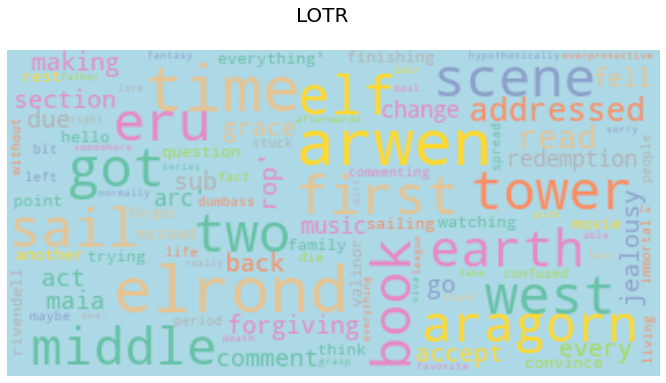

In [31]:
fig = plt.figure(1, figsize=(12, 6))
plt.axis('off')

fig.suptitle("LOTR", fontsize=20)

word_cloud = WordCloud(
    background_color = "lightblue",
    max_words=100,
    max_font_size=40,
    colormap="Set2"
).generate(str(lotr_df["alltext"].values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Putting my domain knowledge into practice, this word cloud is accurate. Characters like Aragon, Arwen and Elrond are very important in LOTR storyline.

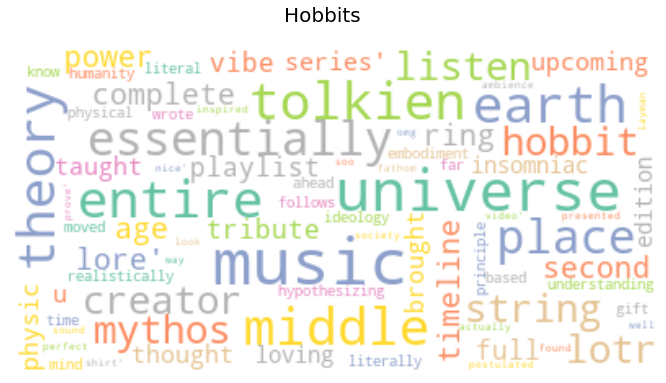

In [32]:
fig = plt.figure(1, figsize=(12, 6))
plt.axis('off')

fig.suptitle("Hobbits", fontsize=20)

word_cloud = WordCloud(
    background_color = "white",
    max_words=100,
    max_font_size=40,
    colormap="Set2"
).generate(str(hobb_df["alltext"].values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

On the contrast, the word cloud for Hobbit is not insightful on which word is useful.

### Combining both datasets 

In [33]:
tolkien = pd.concat([lotr_df, hobb_df], axis = 0)

In [34]:
tolkien.reset_index(drop=True)

,subreddit,alltext,topic
0,lordoftherings,sub act every comment section rop,LOTR
1,lordoftherings,forgiving eru making maia fell grace due jealo...,LOTR
2,lordoftherings,music change everything,LOTR
3,lordoftherings,everything rop showrunners said interview far ...,LOTR
4,lordoftherings,fight well choreographed despite short simple ...,LOTR
...,...,...,...
3365,TheHobbit,gollum read harry potter sorcerer stone chapte...,HOBB
3366,TheHobbit,dagor dagorath j r r tolkien short film reacti...,HOBB
3367,TheHobbit,omg look soo nice,HOBB
3368,TheHobbit,found perfect shirt,HOBB


In [35]:
tolkien.shape

(3370, 3)

<br>
Map LOTR to 0 and Hobbit to 1

In [36]:
tolkien["topic"] = tolkien["topic"].map({"LOTR":0,
                                         "HOBB":1})

In [37]:
tolkien.shape

(3370, 3)

## Preprocessing and Modeling
---

In [38]:
X = tolkien["alltext"]
y = tolkien["topic"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [40]:
X_train.shape

(2696,)

In [41]:
y_train.shape

(2696,)

In [42]:
y_test.shape

(674,)

### Baseline model

In [43]:
tolkien["topic"].value_counts(normalize = True)

0    0.508605
1    0.491395
Name: topic, dtype: float64

In [44]:
preds = [0]*len(y_test)

 
Model metrics


,Calculation
Specificity,1.000000
Accuracy,0.508902


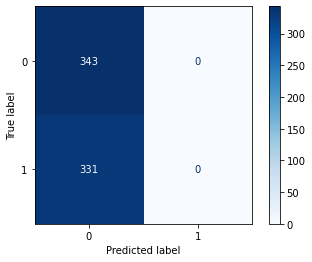

In [45]:
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

models = ["Specificity", "Accuracy"]

data_1 = [(tn / (tn+fp)),
          accuracy_score(y_test, preds)
         ]

cm_comparison = pd.DataFrame(data=data_1, 
                             index=models,
                             columns = ["Calculation"])
print(" ")
print("Model metrics")
display(cm_comparison)   

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues');

The baseline model will classify post to LOTR accurately at 50.9%. Since most of the count belongs to LOTR.

### Function Creation for modelling

Creating a function for Vectorizer, Modelling, Pipeline and GridSearchCV

In [46]:
def vector_model(vector, vactorizer, model_name, model, pipe_params):
    
    # Define the pipeline first
    pipe = Pipeline([
        (vector, vactorizer),
        (model_name, model)
    ])
    
    
    # Define grid search
    gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)
    
    
    # Do fitting
    gs.fit(X_train, y_train)
    
    
    # Display gridsearch result
    print(f"{model} Best Score: {gs.best_score_}")
    print(f"{model} Train Score: {gs.score(X_train, y_train)}")
    print(f"{model} Test Score: {gs.score(X_test, y_test)}")
    print(" ")
    print(f"{model} Best estimators: {gs.best_params_}")
    print(" ")
    print(" ")
    
    # The coef display
    if model_name == 'nb': 
        print("Useful words to differentiate the topics")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        log_prob_diff = gs.best_estimator_.steps[1][1].feature_log_prob_[1] - gs.best_estimator_.steps[1][1].feature_log_prob_[0]
        df_coef = pd.DataFrame(log_prob_diff, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
    
    elif model_name == 'lr':
        print("Useful words for Hobbit")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.lr.coef_
        coef_val = np.exp(coef_val).T
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
        print("Useful words for LOTR")
        display(df_coef.sort_values(by = ['coef'], ascending = True).head(20))
        
    elif model_name == 'rf':
        print("Useful words to differentiate the topics")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.rf.feature_importances_
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
        
    else:
        pass
        
    # The confusion matrix
    preds = gs.predict(X_test)

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
   
    models = ["Specificity", "Accuracy", "Sensitivity / Recall", "Precision", "F1 Score"]
    
    data_1 = [(tn / (tn+fp)),
              accuracy_score(y_test, preds),
              recall_score(y_test, preds),
              precision_score(y_test, preds),
              f1_score(y_test, preds)
             ]

    cm_comparison = pd.DataFrame(data=data_1, 
                                 index=models,
                                 columns = ["Calculation"])
    print(" ")
    print("Model metrics")
    display(cm_comparison)   
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    

<br>
Now the function is done, shall proceed with modelling using Count Vectorizer and TFID Vectorizer. 

### Count Vectorizer

#### Naive Bayes model

In [47]:
pipe_params_cv_nb = {
    'cvec__min_df': [2], # [2, 3],
    'cvec__max_df': [0.75], # [0.75, 0.9, 0.95],
    'cvec__max_features': [3000], # [2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 2)] # [(1, 1), (1, 2), (1, 3), (1, 4)]
}

# More hyper parameters were tried for Naive Bayes model to get a better score and 
# max features added more selection to reduce overfitting

MultinomialNB() Best Score: 0.7014107056964201
MultinomialNB() Train Score: 0.798219584569733
MultinomialNB() Test Score: 0.7032640949554896
 
MultinomialNB() Best estimators: {'cvec__max_df': 0.75, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
 
 
Useful words to differentiate the topics


,coef
edit,3.177472
mirkwood,3.017129
spider,3.017129
bard,2.926157
smaug,2.860560
thorin,2.860560
blu ray,2.826074
bombur,2.826074
blu,2.826074
desolation,2.743836


 
Model metrics


,Calculation
Specificity,0.758017
Accuracy,0.703264
Sensitivity / Recall,0.646526
Precision,0.720539
F1 Score,0.681529


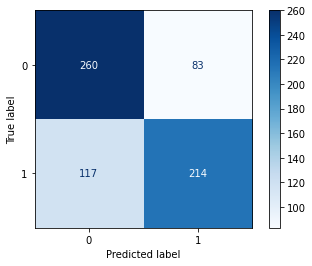

In [48]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'nb', MultinomialNB(), pipe_params_cv_nb)

Using Count Vectorizer with Naive Bayes model, the top 5 useful words in classifying the posts are edit, mirkwood, spider, bard and smaug.
<br>

Putting domain knowledge into use, edit might seems wrong to most. But it is referring to the 2 LOTR versions that were released. One is the cinema edit and another one is the uncut version. Fans who are into LOTR enough to have discussion on online forums would highly likely seen both versions. Thus, edit is a word  to determine if the post belongs to LOTR. Likewise for mirkwood and spider. The other 2 (bard and smaug) are for classifying post to the hobbits.  

#### KNN model

In [49]:
pipe_params_knn = {
    'cvec__min_df': [2], # [2, 3],
    'cvec__max_df': [0.9], # [0.9, 0.95],
    'cvec__max_features': [2000], # [2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 4)], # [(1, 1), (1, 2), (1, 3), (1,4)],
    'knn__n_neighbors': [5] # [5,11] 
}

KNeighborsClassifier() Best Score: 0.6702535559678416
KNeighborsClassifier() Train Score: 0.7800445103857567
KNeighborsClassifier() Test Score: 0.6528189910979229
 
KNeighborsClassifier() Best estimators: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'knn__n_neighbors': 5}
 
 
 
Model metrics


,Calculation
Specificity,0.682216
Accuracy,0.652819
Sensitivity / Recall,0.622356
Precision,0.653968
F1 Score,0.637771


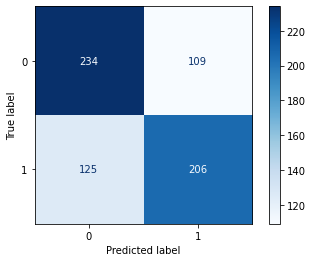

In [50]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'knn', KNeighborsClassifier(), pipe_params_knn)

KNN model performs badly here with only 0.653 as the accuracy score.

#### Logistic Regression model

In [51]:
pipe_params_cv_lr = {
    'cvec__min_df': [2], # [2, 3],
    'cvec__max_df': [0.75], # [0.75, 0.9, 0.95], 
    'cvec__max_features': [5000], # [1000, 2000, 3000, 4000, 5000, 6000], 
    'cvec__ngram_range': [(1, 3)] # [(1, 2), (1, 3), (1, 4)] 
}

# More hyper parameters were tried for Logistic Regression model to get a better score and 
# max features added more selection to reduce overfitting

LogisticRegression() Best Score: 0.7091905449048306
LogisticRegression() Train Score: 0.9043026706231454
LogisticRegression() Test Score: 0.7047477744807121
 
LogisticRegression() Best estimators: {'cvec__max_df': 0.75, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3)}
 
 
Useful words for Hobbit


,coef
gollum,6.044914
hobbit,5.791026
bilbo,5.331120
smaug,5.310813
ring tattoo,3.554948
middle earth lore,3.497788
earth lore,3.497788
bombur,3.303256
breakdown,3.052917
bofur,2.998647


Useful words for LOTR


,coef
eye,0.294647
mordor,0.324077
morgoth,0.325546
gondolin,0.353028
isengard,0.361230
fellowship,0.369753
frodo,0.377680
aragorn,0.383482
dwalin,0.384617
age,0.387679


 
Model metrics


,Calculation
Specificity,0.778426
Accuracy,0.704748
Sensitivity / Recall,0.628399
Precision,0.732394
F1 Score,0.676423


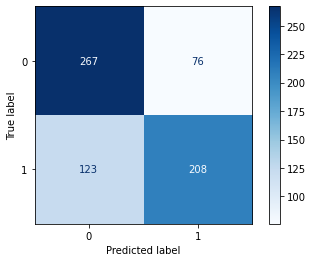

In [52]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'lr', LogisticRegression(), pipe_params_cv_lr)

Using Count Vectorizer with Logistics Regression model, some of useful words in classifying Hobbits are thorin, smaug, bilbo, bombur and dwarf. While, some of useful words in classifying LOTR are aragon, eye, mordor, isengard and morgoth.
<br>

Putting domain knowledge into use, non-LOTR fans might wonder is eye supposed to be a stop word instead and LOTR fans might wonder who is morgoth. Eye is the main enemy in the movie of LOTR. Morgoth was the dark lord way before the events of LOTR and also the cause of terror in LOTR indirectly.

#### Random Forest

In [53]:
rf_params_cv = {
    'cvec__min_df': [3], # [2, 3],
    'cvec__max_df': [0.9], # [0.9, 0.95],
    'cvec__max_features': [5000], # [2000, 3000, 5000],
    'cvec__ngram_range': [(1 ,2)], # [(1, 2), (1, 3), (1, 4)],
    'rf__n_estimators': [100], # [100, 150, 200],
    'rf__max_depth': [15] # [5, 10, 15]
}

RandomForestClassifier() Best Score: 0.712161753590325
RandomForestClassifier() Train Score: 0.7614985163204748
RandomForestClassifier() Test Score: 0.6913946587537092
 
RandomForestClassifier() Best estimators: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'rf__max_depth': 15, 'rf__n_estimators': 100}
 
 
Useful words to differentiate the topics


,coef
hobbit,0.126482
ring,0.041687
lord ring,0.030980
smaug,0.027093
bilbo,0.024217
lord,0.021314
thorin,0.016123
hobbit trilogy,0.013690
dwarf,0.013116
gollum,0.013054


 
Model metrics


,Calculation
Specificity,0.862974
Accuracy,0.691395
Sensitivity / Recall,0.513595
Precision,0.783410
F1 Score,0.620438


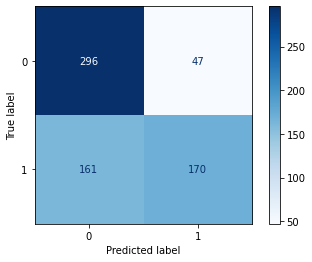

In [54]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'rf', RandomForestClassifier(), rf_params_cv)

Using Count Vectorizer with Random Forest model, the top 5 useful words in classifying the posts are hobbit, ring, lord ring, lord and bilbo.
<br>

### TFID vectorizer

#### Naive Bayes model

In [55]:
pipe_params_tvec_nb = {
    "tvec__min_df": [1], #[1, 2, 3],
    "tvec__max_df": [0.75], #[0.75, 0.9, 1],
    "tvec__max_features": [6000], # [1000, 2000, 3000, 4000, 5000, 6000], 
    "tvec__ngram_range": [(1, 3)] # [(1, 1), (1, 2), (2, 3), (1, 3), (1, 4)]
}

# More hyper parameters were tried for Naive Bayes model to get a better score and 
# max features added more selection to reduce overfitting

MultinomialNB() Best Score: 0.7092008520579949
MultinomialNB() Train Score: 0.8746290801186943
MultinomialNB() Test Score: 0.7151335311572701
 
MultinomialNB() Best estimators: {'tvec__max_df': 0.75, 'tvec__max_features': 6000, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 3)}
 
 
Useful words to differentiate the topics


,coef
smaug,1.879352
desolation,1.775992
bilbo,1.775106
bombur,1.772992
desolation smaug,1.755856
edit,1.722410
journey,1.685363
mirkwood,1.583412
dwarf,1.576026
earth lore,1.550128


 
Model metrics


,Calculation
Specificity,0.746356
Accuracy,0.715134
Sensitivity / Recall,0.682779
Precision,0.722045
F1 Score,0.701863


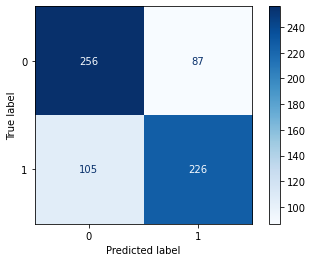

In [56]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'nb', MultinomialNB(), pipe_params_tvec_nb)

Using TFID Vectorizer with Naive Bayes model, the top 5 useful words in classifying the posts are desolation, desolation smaug, bilbo, bombur and smaug.
<br>

Putting domain knowledge into use, desolation might seems wrong to most. But it is referring to the 2nd Hobbit movie: Desolation of Smaug. Thus, desolation is a word to determine if the post belongs to the Hobbit. Likewise for bilbo and bombur, the main character of Hobbits.

#### KNN model

In [57]:
pipe_params_tvec_knn = {
    "tvec__max_features": [2000], # [2000, 3000, 4000, 5000], 
    "tvec__ngram_range": [(1, 3)], # [(1, 1), (1, 2), (1, 3), (1, 4)],
    "knn__n_neighbors": [5] # [5, 11] 
}

KNeighborsClassifier() Best Score: 0.5845571359857075
KNeighborsClassifier() Train Score: 0.7303412462908012
KNeighborsClassifier() Test Score: 0.6068249258160238
 
KNeighborsClassifier() Best estimators: {'knn__n_neighbors': 5, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 3)}
 
 
 
Model metrics


,Calculation
Specificity,0.685131
Accuracy,0.606825
Sensitivity / Recall,0.525680
Precision,0.617021
F1 Score,0.567700


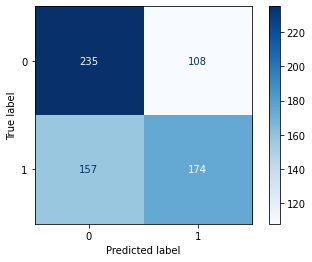

In [58]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'knn', KNeighborsClassifier(), pipe_params_tvec_knn)

The accuracy for KNN model using TFID vectorizer is worse than using count vectorizer.

#### Logistic Regression model

In [59]:
pipe_params_tvec_lr = {
    "tvec__min_df": [2], #[2, 3]
    "tvec__max_df": [0.9], #[0.9, 0.95]
    "tvec__max_features": [5000], # [3000, 4000, 5000, 6000],
    "tvec__ngram_range": [(1, 3)] # [(1, 1), (1, 2), (2, 4), (1, 3), (1, 4)]
}

# More hyper parameters were tried for Logistic Regression model to get a better score and 
# max features added more selection to reduce overfitting

LogisticRegression() Best Score: 0.7232927918642205
LogisticRegression() Train Score: 0.8675816023738873
LogisticRegression() Test Score: 0.7136498516320475
 
LogisticRegression() Best estimators: {'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
 
 
Useful words for Hobbit


,coef
hobbit,222.263938
bilbo,21.084557
gollum,14.443830
smaug,9.261529
dwarf,6.732842
earth lore,5.453726
middle earth lore,5.453726
thorin,4.819926
edit,3.476050
bombur,3.453213


Useful words for LOTR


,coef
ring,0.111069
lord,0.155078
frodo,0.175312
aragorn,0.249595
lotr,0.260413
black,0.268643
lord ring,0.268696
mordor,0.270472
fellowship,0.276850
power,0.288995


 
Model metrics


,Calculation
Specificity,0.787172
Accuracy,0.713650
Sensitivity / Recall,0.637462
Precision,0.742958
F1 Score,0.686179


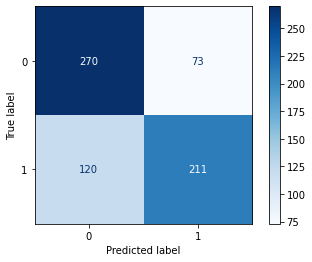

In [60]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'lr', LogisticRegression(), pipe_params_tvec_lr)

Using TFID Vectorizer with Logistics Regression model, some of useful words in classifying Hobbits are thorin, smaug, bilbo, bombur and dwarf. While, some of useful words in classifying LOTR are aragon, frodo, galadriel, fellowship and black.

Putting domain knowledge into use, non-LOTR fans might wonder is black supposed to be a stop word instead. Black is referring to the Black riders in the LOTR movies.

#### Random Forest

In [61]:
rf_params_tv = {
    "tvec__max_features": [3000], #[2000, 3000, 4000, 5000],
    "tvec__ngram_range": [(1, 3)], #[(1, 2), (1, 3), (1, 4)],
    'rf__n_estimators': [100], #[100, 150, 200],
    'rf__max_depth':  [15] # [5, 10, 15]
}

RandomForestClassifier() Best Score: 0.7036336150621865
RandomForestClassifier() Train Score: 0.7681750741839762
RandomForestClassifier() Test Score: 0.6973293768545994
 
RandomForestClassifier() Best estimators: {'rf__max_depth': 15, 'rf__n_estimators': 100, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 3)}
 
 
Useful words to differentiate the topics


,coef
hobbit,0.125868
lord,0.046959
lord ring,0.036972
ring,0.035631
bilbo,0.030995
smaug,0.026315
thorin,0.018060
gollum,0.017862
lore,0.014410
dwarf,0.013325


 
Model metrics


,Calculation
Specificity,0.865889
Accuracy,0.697329
Sensitivity / Recall,0.522659
Precision,0.789954
F1 Score,0.629091


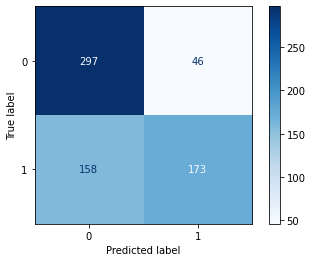

In [62]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'rf', RandomForestClassifier(), rf_params_tv)

Using TFID Vectorizer with Random Forest model, the top 5 useful words in classifying the posts are hobbit, ring, lord ring, lord and smaug.

## Model Comparison
---

| Vectorizer | Model         | Best score | Train score | Test Score | Accuracy | Specificity | Recall | Precision | F1 Score |
|------------|---------------|------------|-------------|------------|----------|-------------|--------|-----------|----------|
| NA         | Baseline      | 0.509      | 0.509       | 0.509      | 0.509    | 1.000       | 0.000  | 0.000     | 0.000    |
| Count      | Naive Bayes   | 0.701      | 0.798       | 0.703      | 0.703    | 0.758       | 0.647  | 0.721     | 0.682    |
| Count      | KNN           | 0.670      | 0.780       | 0.653      | 0.653    | 0.682       | 0.622  | 0.654     | 0.637    |
| Count      | Logistics Reg | 0.709      | 0.904       | 0.705      | 0.705    | 0.778       | 0.628  | 0.732     | 0.676    |
| Count      | Random Forest | 0.717      | 0.766       | 0.693      | 0.693    | 0.857       | 0.523  | 0.779     | 0.626    |
| TFID       | Naive Bayes   | 0.709      | 0.875       | **0.715**  | 0.715    | 0.746       | 0.683  | 0.722     | 0.702    |
| TFID       | KNN           | 0.585      | 0.730       | 0.607      | 0.607    | 0.685       | 0.526  | 0.617     | 0.568    |
| TFID       | Logistics Reg | **0.723**  | 0.868       | **0.714**  | 0.714    | 0.787       | 0.637  | 0.743     | 0.686    |
| TFID       | Random Forest | 0.714      | 0.769       | 0.693      | 0.693    | 0.857       | 0.523  | 0.779     | 0.626    |

Observations from the table above:
* The dataset has a balanced distribution between the 2 topic with ~51% belonging to LOTR and ~49% belonging to hobbit.
* Hence, accuracy score will be used mainly for determining the model performance instead of the F1 score.
* The best accuracy scores from the table above are models using **TFID vectorizer**.
* Naive Bayes and Logistics Regression model scored best with 0.715 and 0.714 respectively.
* Comparing the two models, **I've decided to chose Logistics Regression** instead of Naive Bayes. This is because the Best score for Logistics Regression is better than Naives Bayes (0.723 > 0.709)
* There is lesser of an overfit for Logistics Regression as well.
* The other models performing badly with accuracy under 0.70.

## Conclusion and Recommendations

### Conclusion

Based on the results and findings, fans should use the TFID Vectorizer, Logistic Regression model to differentiate if the post is related to LOTR or The Hobbits. 
<br>
The main characters in the movie are important to differentiate between the movies. Dwarf characters such as Thorin, Bombur are prominent in The Hobbits movie as well as in the online discussions. 
<br>
While, LOTR discussions are mainly about the foes (black riders, eye, morgoth). 
<br>
Characters such as bilbo, gandalf are in existence in both movies. Hence, it is best for the production team to state that clearly during fans meet and greet session / conference to clear the confusion. 
<br>

### Recommendation

Recommend the production team to work with YouTubers who specialize in recaps / Tolkien works. In order to provide bite sized videos on the background for LOTR fans before the upcoming series.
<br>
Also, recommend the production team to work with streaming platform (mainly Amazon Prime) to stream LOTR and the Hobbits trilogy. 
<br>
It would be recommended to have the uncut version on streaming platform. Then, the fans will get more details and clearer idea on the events.
<br>
Future work will recommend for the production team to use other online discussion forums to gather data.